# Generate Census Data
In this notebook we will generate random points inside São Paulo City Census Sectors. This information will be used later for StreetView Image Retrieval and Image x IDH / IPVS 2010 cross reference

In [1]:
import shapefile
import shapely.geometry
import random
import simpledbf
import pandas as pd
import utm
import seaborn as sns
import matplotlib.pyplot as plt

random.seed(42)

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


First, we import the Shapefiles that contain the 2010 Census Sector geometries. These files can be found at the Geosampa website (http://geosampa.prefeitura.sp.gov.br > Dados Abertos > População > Setor Censitário > Shapefile > SIRGAS_SETOR_CENSITARIO_2010)

Also, let's import the DBF files that contain some data over the sectors:
- ID: ID of the sector. Also, it indicates the order of the geometries in the shapefile file.
- AREA_M: Area of the sector, in square meters.
- CODSETOR: ID of the sector. Composed from the hierarchy of ID from the 2010 census data
- TIPO: Sector type (Urbano = Urban, Rural = Rural)
- POPULACAO: Sector population. Still trying to understand what the missing values are.
- IPVS_V10: Índice Paulista de Vulnerabilidade Social (Paulista Index of Social Vulnerability). Missing values seems to be tied with POPULACAO missing values.

In [2]:
sf = shapefile.Reader("./data/polygons/LAYER_CENSITARIO/SIRGAS_SETOR_CENSITARIO_2010")
dbf = simpledbf.Dbf5("./data/polygons/LAYER_CENSITARIO/SIRGAS_SETOR_CENSITARIO_2010.dbf")
df_dbf = dbf.to_dataframe()

df_dbf.head()

,ID,AREA_M,CODSETOR,TIPO,POPULACAO,IPVS_V10
0,1,311095.19,355030803000062,URBANO,NaN,NaN
1,2,49953.56,355030803000069,RURAL,NaN,NaN
2,3,238621.26,355030803000063,RURAL,NaN,NaN
3,4,6912969.36,355030803000049,RURAL,32.0,0.0
4,5,81244.42,355030803000072,RURAL,NaN,NaN


Let's do some exploration on the above dataset. Below we use seaborn to plot the join distribution of AREA_M and POPULACAO

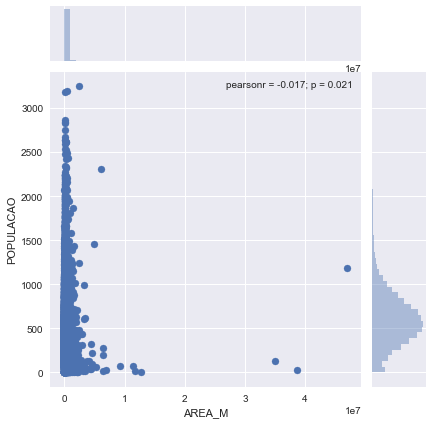

In [3]:
%matplotlib inline

sns.jointplot(data=df_dbf, x="AREA_M", y="POPULACAO")


It's easy to see that we have some AREA_M outliers that are messing up our visualization. Let's take a look by removing the top 5% sector areas from our analysis. We also change the plot to use a KDE (Kernel Density Estimation) to allow us beter insights at the data.

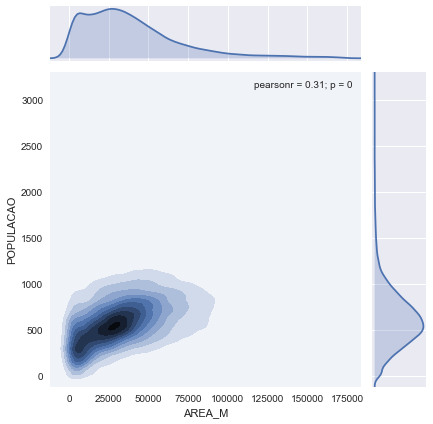

In [4]:
%matplotlib inline

q_95 = df_dbf["AREA_M"].quantile(0.95)

sns.jointplot(
    data=df_dbf[df_dbf["AREA_M"] < q_95], 
    x="AREA_M", 
    y="POPULACAO",
    kind="kde"
)

Is AREA_M related to TIPO? We expect that a Rural Sector to be bigger than a Urban sector. Let's find out.

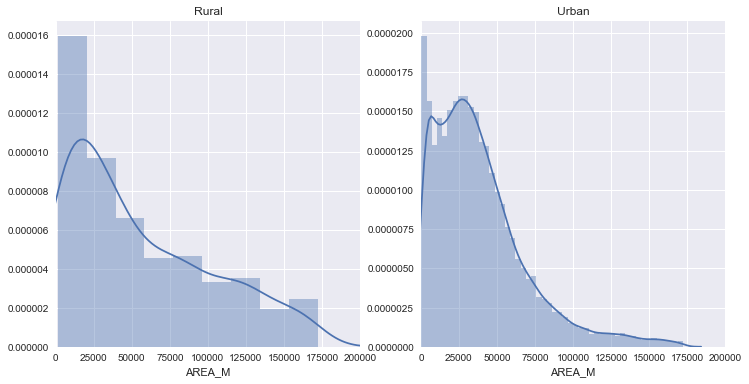

In [5]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6),)

ax1.set_title("Rural")
ax1.set(xlim=(0,200000))
sns.distplot(df_dbf.loc[
    (df_dbf["TIPO"] == "RURAL")  & (df_dbf["AREA_M"] < q_95),
    "AREA_M"
], ax=ax1)

ax2.set_title("Urban")
ax2.set(xlim=(0,200000))
sns.distplot(df_dbf.loc[
    (df_dbf["TIPO"] == "URBANO") & (df_dbf["AREA_M"] < q_95),
    "AREA_M",    
], ax=ax2)

Ok. Now that we have some knowledge about our dataset, let's start working on our actual problem. We want to generate random points inside a Census Sector, that will be used afterwards for Streetview image retrieval. For this, let's define a generator that will calculate this ccoordinates.

In [6]:
def coordinate_generator(shape, n):
    #UTM Region of the shapefile
    UTM_REGION_1 = 23
    UTM_REGION_2 = "K"    
    #Converting shape to shapely
    sh = shapely.geometry.shape(shape) 
    #Getting bounding box from shape
    x_min, y_min, x_max, y_max = tuple(map(float,shape.bbox))
    #Generator Loop
    i = 0
    while i < n:
        #Generate a random point inside the bounding box, and check
        #if it falls inside the sector geometry
        pt_x = x_min+random.uniform(0,1)*(x_max-x_min)
        pt_y = y_min+random.uniform(0,1)*(y_max-y_min)
        pt = shapely.geometry.Point(pt_x,pt_y)
        if sh.contains(pt):
            #Convert to (latitude,longitude) tuples
            yield utm.to_latlon(pt.x, pt.y, UTM_REGION_1, UTM_REGION_2)    
            i = i + 1

We can now use our newly defined generator to generate 10 random points for each census sector. We also take the opportunity to provide and example of how to use IPyWidgets to build a nice progress bar suited for longer processes

In [7]:
from ipywidgets import IntProgress, HTML, VBox
from IPython.display import display

progress = IntProgress(min=df_dbf.index.min(), max=df_dbf.index.max(), description="Generating")
label = HTML()
box = VBox(children=[label, progress])
display(box)

census_coord = []
shape_list = sf.shapes()

try:
    for idx, row in df_dbf.iterrows():
        if idx % 100 == 0: #Update from 100 to 100
            progress.value = idx
            label.value = "{idx}/{maxv}".format(idx=idx,maxv=df_dbf.index.max())
        shape = shape_list[idx]
        census_coord = census_coord + [(idx,i, pt[0], pt[1]) for i, pt in enumerate(coordinate_generator(shape,10))]
    
    #Signal successful execution
    progress.value = df_dbf.index.max()
    progress.bar_style  = "success"
    label.value = "Completo"
except:
    #Update bar to show error, and re-raise the exception
    progress.bar_style  = "danger"
    label.value = "Error!"
    raise

Now, let's save our generated coordinates to a CSV file. This way, if we need to continue our work on another day we can do it without having to generate all our data again

In [9]:
df_census = pd.DataFrame(census_coord,columns=["ID_CENSUS", "ID_COORDINATE", "VL_LATITUDE", "VL_LONGITUDE"])
df_census.to_csv(r"./data/generated/census_coordinates.csv")
df_census.head()

,ID_CENSUS,ID_COORDINATE,VL_LATITUDE,VL_LONGITUDE
0,0,0,-23.409850,-46.817878
1,0,1,-23.406803,-46.823728
2,0,2,-23.406565,-46.819952
3,0,3,-23.406206,-46.823704
4,0,4,-23.408079,-46.817285


Finally, we plot some of the coordinates on a map using the gmaps module (https://github.com/pbugnion/gmaps) to assess if our program is doing what we expected from it. It surely seems so!

In [10]:
import gmaps
import gmaps.datasets
import sensitive #Module ignored by GIT which contains sensitive information like my Google Maps API Key

gmaps.configure(api_key=sensitive.API_KEY) # Your Google API key


points = df_census[["VL_LATITUDE","VL_LONGITUDE"]].iloc[range(1000,1010)].values

fig = gmaps.figure()
fig.add_layer(gmaps.symbol_layer(points,fill_color="green", stroke_color="green"))
fig

And thats it! On the next notebookk we will write some code to retrieve the Streetview images for the coordinates generated here.